<a href="https://colab.research.google.com/github/uprestel/AutoNeRF/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmentation project - Mathematical Image Processing
In this notebook we have implemented the algorithm from the paper "A convex approach to minimal partitions" [1]. The goal of this method is to partition an
image into $k$ given classes.


Literature


*   [1]
*   Listeneintrag





---


To get started, we first clone our repository, to get access to example images

In [ ]:
!git clone https://github.com/uprestel/Segmentation
%cd Segmentation/

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image



def load_images(paths, grayscale=False):
    """
        Small utility function to load images

        Parameters
        ----------
            paths: list
                List of absolute paths to the images
            grayscale: bool
                Optional boolean to specify whether the images
                should be loaded as grayscale images
        
        Returns
        ----------
            images: List
                A list of loaded PIL-Image-objects
    """

    images = []
    for path in paths:
        img = Image.open(path)
        if grayscale:
            img = img.convert('L')
        images.append(img)
    return images  


def plot(images, titles, figsize=(10,5)):
    """
        Small utility function to plot images

        Parameters
        ----------
            images: list
            titlrs: list
            figsize: tuple

        Returns
        ----------
    """
    n_images = len(images)
    
    fig = plt.figure(figsize=figsize)
    
    for i in range(n_images):

        ax = fig.add_subplot(1,n_images, i+1)
        ax.imshow(images[i], cmap='gray')
        ax.axis('off')
        ax.set_title(titles[i])
        
    plt.show()



path  /content/Segmentation/Segmentation


## Plots

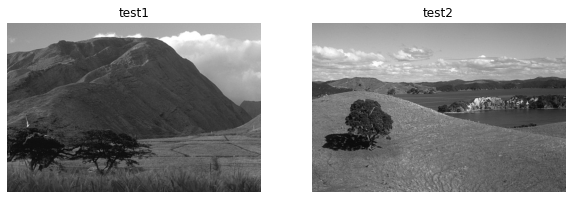

In [17]:
images = load_images([
    "data/28083.jpg",
    "data/36046.jpg",
], grayscale=True)
plot(images, ["test1", "test2"])

## Projection definitions
In this section, the necessary projection operations for Chambolle-Pcck are implemented

## Projection $\Pi_K$

In [19]:
from numba import njit, prange

@njit
def sigma(i,j):
    return np.sqrt(np.abs(i-j))

@njit
def Projection_K(Q, tolerance, maxiter):
    """
        Projection onto the convex set K. The implementation follows 
        the algorithm from [TODO] very closely.

        Parameters
        ----------
        Q: np.array
            Input array
        tolerance: float
            The tolerance for how much Q has to change within each iteration.
            If the change is smaller than the tolerance, the algorithm terminates
        sigmas: np.ndarray
            Precomputed values for sigma
        
        Returns
        ----------
            The projection of Q onto the convex set K
    """


    k, d = Q.shape
    q = np.zeros((k,k,d))

    for _ in range(maxiter):
        Qold = Q.copy()

        for i2 in range(0, k):
            for i1 in range(0, i2):
                Qhat = Q[i2] - Q[i1] + q[i1,i2]
                norm_Qhat = np.linalg.norm(Qhat)
                
                if norm_Qhat < 1e-10:
                    return Q

                Qhathat = np.abs(norm_Qhat - sigma(i1, i2)) * (Qhat / norm_Qhat)
                Q[i1] += 0.5*(Qhathat - q[i1,i2])
                Q[i2] -= 0.5*(Qhathat - q[i1,i2])
                q[i1,i2] = Qhathat
        change = np.linalg.norm(Qold-Q, 2)
        if change < tolerance:
            break
    return Q

### Projection $\Pi_S$

In [20]:

def partition(U, v, v_k):
    G = []
    L = []
    #G = List()
    #L = List()
    for j in U:
        if v[j] >= v_k:
            G.append(j)
        else:
            L.append(j)

    return np.array(G),np.array(L)


def projection_S_old(v, z=1):
    """
        Linear time projection algorithm onto the simplex S
    """
    n = v.shape[0]
    U = np.arange(n)
    #print(U)
    p = 0
    s = 0

    while U.shape[0] > 0:
        k = np.random.choice(U)
        v_k = v[k]
        
        G,L = partition(U, v, v_k)
        
        delta_p = len(G)
        delta_s = v[G].sum()

        if (s + delta_s) - (p + delta_p)*v_k < z:
            
            s += delta_s
            p += delta_p
            U = L
            
        else:
            
            U = np.setdiff1d(G, k)
            
    theta = (s - z)/p
    w = np.maximum(v - theta, 0)
    return w

#v = np.array([1,2,3,4,5,6,7,8,9,1.1,6.6])
#z = 7
#projection_S(v,z)

##Confirm correctness of projections

In [22]:
v = np.array([1.2, 3.4, 6.8, -1])
#for _ in range(100):
print(projection_S( v, 1))

[0. 0. 1. 0.]


In [23]:
v = np.array([1.2, 3.4, 6.8, -1])
b =(v>=2)
v[b]

array([3.4, 6.8])

In [24]:
v = np.array([1.2, 33.4, -6.8, -1])
projection_S( v, 1)

array([0., 1., 0., 0.])

## Discrete Calculus - implementation of $\text{div}^h$, $\nabla^h$

In [25]:

@njit
def computeGradient(img, h=1): #img = (N,M,K)
    """
        Implementation of the discrete gradient as described in the lecture notes

        Parameters:
            img: np.ndarray
                The input image
            h: float
                The step length between the pixels of the image. By default,
                is is set to 1

        Returns:
            The two directions of the 
    """
    

    K = 1
    if len(img.shape) > 2:
        K = img.shape[2]
                        
                        
    D_shape = (img.shape[0]+2, img.shape[1]+2,K)
    
    D = np.zeros(D_shape)                                       
    D[1:-1, 1:-1] = img[:,:]
                
    Di = D[2:, 1:-1]
    Di_ = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
    Di_[0:-1, :, :] = img[:-1, :, :]
    

    
    Dj = D[1:-1, 2:]
    Dj_ = np.zeros((img.shape[0], img.shape[1], img.shape[2]))
    Dj_[:, 0:-1, :] = img[:, :-1,:]
    vi = (Di-Di_)/h 
    vj = (Dj-Dj_)/h 

    return np.stack( (vi, vj), 2 )
    


def div(E):
    """
        Implementation of the discrete divergence as described in the lecture
        notes.

        Parametets:
    """
    
    S = E.shape
    D = E.copy()
    
    
    for j in range(0, E.shape[1]):
        D[0,j,0]  = E[0,j,0]
        for i in range(1, E.shape[0]-1):
            D[i,j,0]  = E[i,j,0] - E[i+1,j,0]
        D[E.shape[0]-1,j,0]  = -E[E.shape[0]-2,j,0]
        
    for i in range(0, E.shape[0]):
        D[i,0,1]  = E[i,0,1]
        for j in range(1, E.shape[1]-1):
            D[i,j,0]  = E[i,j,0] - E[i,j+1,0]
            
        D[i,E.shape[1]-1,0]  = -E[i,E.shape[1]-2,0]
    
    
    Dr = np.add.reduce(D, 2)
    return Dr

(321, 481, 1) (321, 481, 2, 1) (321, 481)


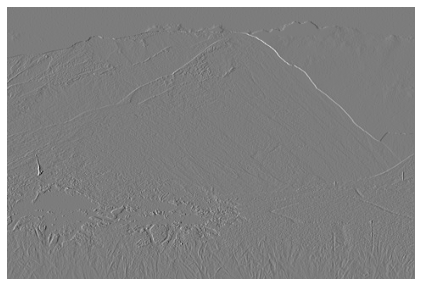

In [27]:
v = np.array(images[0])[:,:,None]
grad=computeGradient(v, 1)
print(v.shape, grad.shape, grad[:,:,0,0].shape)
plot([grad[:,:,1,0]], [""])

In [ ]:
#v = np.array(images[0])[:,:,None]
#grad=computeGradient(v, 1)
#print(v.shape)
#dd,D = div(grad)
#plot([dd[:,:,0], D[:,:,0,0]],["test",""])
#plot([dd[:,:,0]],["test"])

(321, 481)


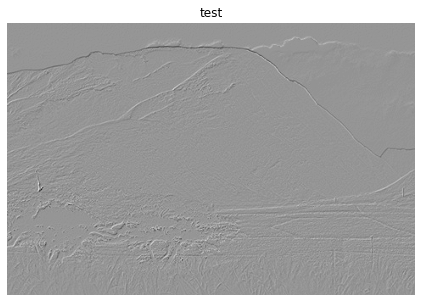

In [29]:
v = np.array(images[0])[:,:,None]
grad=computeGradient(v, 1)
diverg2 = grad[:,:,0,0] + grad[:,:,1,0]
print(diverg2.shape)
plot([diverg2],["test"])

------------------------
## Chambolle-Pock iteration
Now we are ready to implement the Chambolle-Pock iteration, which reads

* $\Xi^0 = 0, \bar{\textbf{V}}^0 = 0, \textbf{V}^0 = 0, \tau>0, \tau'>0$
* $\forall i,j: \quad (\Xi^{n+1})_{i,j} \gets \Pi_K \Big(\Xi^{n}_{i,j} + \tau' (\nabla^h \bar{\textbf{V}}^n)_{i,j}\Big)$
* $\forall i,j: \quad \textbf{V}^{n+1}_{i,j} \gets \Pi_S \Big(\textbf{V}^{n}_{i,j} + \tau \Big[(\text{div}^h {\Xi}^{n+1})_{i,j} - \textbf{G}_{i,j}^h\Big]\Big)$
* $\bar{\textbf{V}}^{n+1} = 2{\textbf{V}}^{n+1} - {\textbf{V}}^{n}$


In [38]:
import time



@njit
def g(I_x, c, lambd=1):
    """

        Mumford-Shah model
        (G_l)_[i,j} = ∫(I(x) - c_l)^2 dx

        Input:
            I_x: intensity value of the image at position x
            c: reference values for the labels.
            lambd: weight parameter 
        return vector of (G_l)_[i,j} w.r.t. label l
    """
    k = len(c)

    Gij = np.zeros(k)
    for l in range(k):
        Gij[l] = lambd*(I_x - c[l])**2 

    return Gij


def chambolle_pock(img, c, iterations, 
                   silent=True, 
                   projk_tolerance = 1e-8, 
                   projk_maxiter = 1000, 
                   tau = 1.0/9.0, 
                   tau_ = 1.0/9.0):
    """
        Implementation of the Chambolle-Pock iteration applied to the 
        minimal partitions problem for segmentation

        Parameters:
            img: np.ndarray
                The input image
            c: tuple
                The number of reference values for each label
            iterations: int
                The number of iterations in Chambolle-Pock
            silent: bool
                optional boolean to show debug information: the time it takes for
                an iteration.
            projk_tolerance: float
                error tolerance for the projection onto K
            projk_maxiter: int
                maximum iteration for the projection step onto K 
            tau: float
                step length parameter for the Chambolle-Pock iteration
            tau_: float
                step length parameter for the Chambolle-Pock iteration
        Returns:
            A segmentation map V for each label
    """

    width, height = img.shape
    print(width, height)

    h = 1
    k = len(c) # 4 classes


    G = np.zeros( (width, height, k) )
    shape_G = G.shape 
    
    for i in range(width):
        for j in range(height):
            
            G[i,j] = g(img[i,j], c)


    Xi = np.zeros((width, height, 2, k))
    V = np.zeros((width, height, k))
    Vbar = np.zeros_like(V)

    # ---< main iteration >---
    for _ in range(iterations):
        
        temp1 = Xi + tau_ * computeGradient(Vbar,1)
        temp2 = V + tau * (div(Xi) - G)

        t0 = time.time()
        for i in range(width):
            for j in range(height):
                Xi[i,j,:,:] = Projection_K(temp1[i,j,:,:], projk_tolerance, projk_maxiter)
                V[i,j,:] = projection_S_old(temp2[i,j,:])

        if not silent:
            print("Finished Chambolle-Pock iteration", _, "after ",time.time()-t0, "seconds")

    return V,Xi


def seg2image(V, c):
    """
        Small helper function to turn a segmentation map into an image
        
        Parameters
        ----------
        V: np.ndarray
            segmentation map
        c: tuple
            Reference values for each class
        Returns
        ----------
    
    """
    zz = np.zeros((V.shape[0], V.shape[1]))
    for l in range(k):
        zz+=c[l]*V[:,:,l]
    return zz

img = np.array(images[0])
c = (0, 90, 180, 255)
V, Xi = chambolle_pock(img, c, 20)


321 481


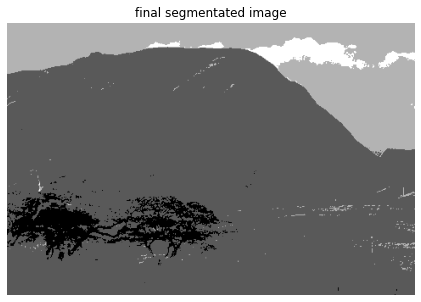

In [40]:
img_seg = seg2image(V, c)
plot([img_seg], ["final segmentated image"])